<a href="https://colab.research.google.com/github/fralfaro/MAT281/blob/main/docs/labs/lab_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MAT281 - Laboratorio N°10

**Objetivo**: Analizar y modelar series temporales de datos delictivos en Montreal, aplicando métodos estadísticos y de aprendizaje automático para la predicción.

> **Nota**: Puede ayudarse de algún asistente virtual como **ChatGPT, Gemini** u otros, así como del autocompletado de **Google Colab**, para avanzar en este laboratorio debido a su extensión.


### Conjunto de datos



<img src="https://svgsilh.com/svg/3350822.svg" width="350"  align="center"/>


El conjunto de datos **`interventionscitoyendo.csv`** proviene del *Service de police de la Ville de Montréal* (SPVM) y contiene el registro de todos los **actos delictivos ocurridos en Montreal entre 2015 y agosto de 2020**.

Cada incidente está clasificado en **categorías generales de delito** e incluye información contextual como la **ubicación geográfica**, la **fecha y hora** del suceso, así como otros atributos relevantes para el análisis.

Este dataset resulta especialmente útil para estudios de **series temporales**, ya que permite agrupar los delitos por intervalos de tiempo (días, semanas, meses) y analizar patrones de comportamiento delictual en la ciudad.

> **Nota**: Puede consultarse más información oficial en el [portal de datos abiertos de Montreal](https://donnees.montreal.ca/ville-de-montreal/actes-criminels).


In [2]:
# librerias

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


# graficos incrustados
plt.style.use('fivethirtyeight')
%matplotlib inline

# parametros esteticos de seaborn
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (12, 4)})

In [3]:
# metrics


def mae(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute error (MAE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.abs(error).mean(), 4)


def mse(targets, predictions) -> float:
    """
    Calculo de la metrica: mean squared error (MSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round((error ** 2).mean(), 4)


def rmse(targets, predictions) -> float:
    """
    Calculo de la metrica: root mean squared error (RMSE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    return round(np.sqrt((error ** 2).mean()), 4)


# b) Percentage errors

def mape(targets, predictions) -> float:
    """
    Calculo de la metrica: mean absolute percentage error (MAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets

    if any(x == 0 for x in targets):
        return np.inf
    else:
        return round(np.abs(error / targets).mean(),4)


def maape(targets, predictions) -> float:
    """
    Calculo de la metrica:  mean arctangent percentage error  (MAAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """

    error = predictions - targets

    if any((x, y) == (0, 0) for x, y in zip(predictions, targets)):
        return np.inf

    else:
        return round(np.arctan(np.abs(error / targets)).mean(),4)


def wmape(targets, predictions) -> float:
    """
    Calculo de la metrica:  weighted mean absolute percentage error (WMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.sum(targets)

    if sum_values == 0:
        return np.inf
    else:
        return round(np.abs(error).sum() / sum_values,4)


def mmape(targets, predictions) -> float:
    """
    Calculo de la metrica: modified mean absolute percentage error (MMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = np.abs(predictions - targets)
    denom = 1 + np.abs(targets)

    return round(np.mean(error / denom),4)


def smape(targets, predictions) -> float:
    """
    Calculo de la metrica: symmetric mean absolute percentage error (SMAPE)
    :param targets: valor real
    :param predictions: valor estimado
    :return: valor de la metrica
    """
    error = predictions - targets
    sum_values = np.abs(predictions) + np.abs(targets)

    if any(x == 0 for x in sum_values):
        return np.inf

    else:
        return round(2 * np.mean(np.abs(error) / sum_values),4)

def summary_metrics(df) -> pd.DataFrame:
    """
    Aplicar las distintas metricas definidas
    :param df:  dataframe con las columnas: ['y','yhat']
    :return: dataframe con las metricas especificadas
    """
    df_result = pd.DataFrame()

    y_true = df['y']
    y_pred = df['yhat']

    df_result['mae'] = [round(mae(y_true, y_pred), 4)]
    df_result['mse'] = [round(mse(y_true, y_pred), 4)]
    df_result['rmse'] = [round(rmse(y_true, y_pred), 4)]

    df_result['mape'] = [round(mape(y_true, y_pred), 4)]
    df_result['maape'] = [round(maape(y_true, y_pred), 4)]
    df_result['wmape'] = [round(wmape(y_true, y_pred), 4)]
    df_result['mmape'] = [round(mmape(y_true, y_pred), 4)]
    df_result['smape'] = [round(smape(y_true, y_pred), 4)]

    # nombre del modelo por defecto
    #try:
    #    model = df['model'][0]
    #    df_result['model'] = [model]
    #except:
    #    df_result['model'] = ['---']

    return df_result

In [4]:
# read data

validate_categorie = [
  'Introduction', 'Méfait','Vol dans / sur véhicule à moteur', 'Vol de véhicule à moteur',
]

df = pd.read_csv("https://raw.githubusercontent.com/fralfaro/MAT281/main/docs/labs/data/interventionscitoyendo.csv", sep=",", encoding='latin-1')
df.columns = df.columns.str.lower()
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df = df.loc[lambda x: x['categorie'].isin(validate_categorie)]
df = df.sort_values(['categorie','date'])
df.head()

,categorie,date,quart,pdq,x,y,longitude,latitude
3462,Introduction,2015-01-01,jour,42.0,297210.375006,5.050179e+06,-73.597273,45.591480
8370,Introduction,2015-01-01,soir,13.0,297145.531007,5.032845e+06,-73.597834,45.435501
11968,Introduction,2015-01-01,nuit,8.0,289215.072000,5.036423e+06,-73.699308,45.467564
12763,Introduction,2015-01-01,soir,27.0,293203.472992,5.045436e+06,-73.648516,45.548740
13686,Introduction,2015-01-01,soir,44.0,298915.433995,5.046912e+06,-73.575381,45.562090


Como tenemos muchos datos por categoría a nivel de día, agruparemos a nivel de **semanas** y separaremos cada serie temporal.

In [5]:
cols = ['date','pdq']
y_s1 = df.loc[lambda x: x.categorie == validate_categorie[0] ][cols].set_index('date').resample('W').mean()
y_s2 = df.loc[lambda x: x.categorie == validate_categorie[1] ][cols].set_index('date').resample('W').mean()
y_s3 = df.loc[lambda x: x.categorie == validate_categorie[2] ][cols].set_index('date').resample('W').mean()
y_s4 = df.loc[lambda x: x.categorie == validate_categorie[3] ][cols].set_index('date').resample('W').mean()



El objetivo de este laboratorio es realizar un **análisis integral** del conjunto de datos, aplicando técnicas de visualización y modelado de series temporales. Para ello, se deben abordar las siguientes tareas:

1. **Visualizar las series temporales** \$y\_{si}, ; i=1,2,3,4\$, generando gráficos que permitan identificar patrones, tendencias y estacionalidades.



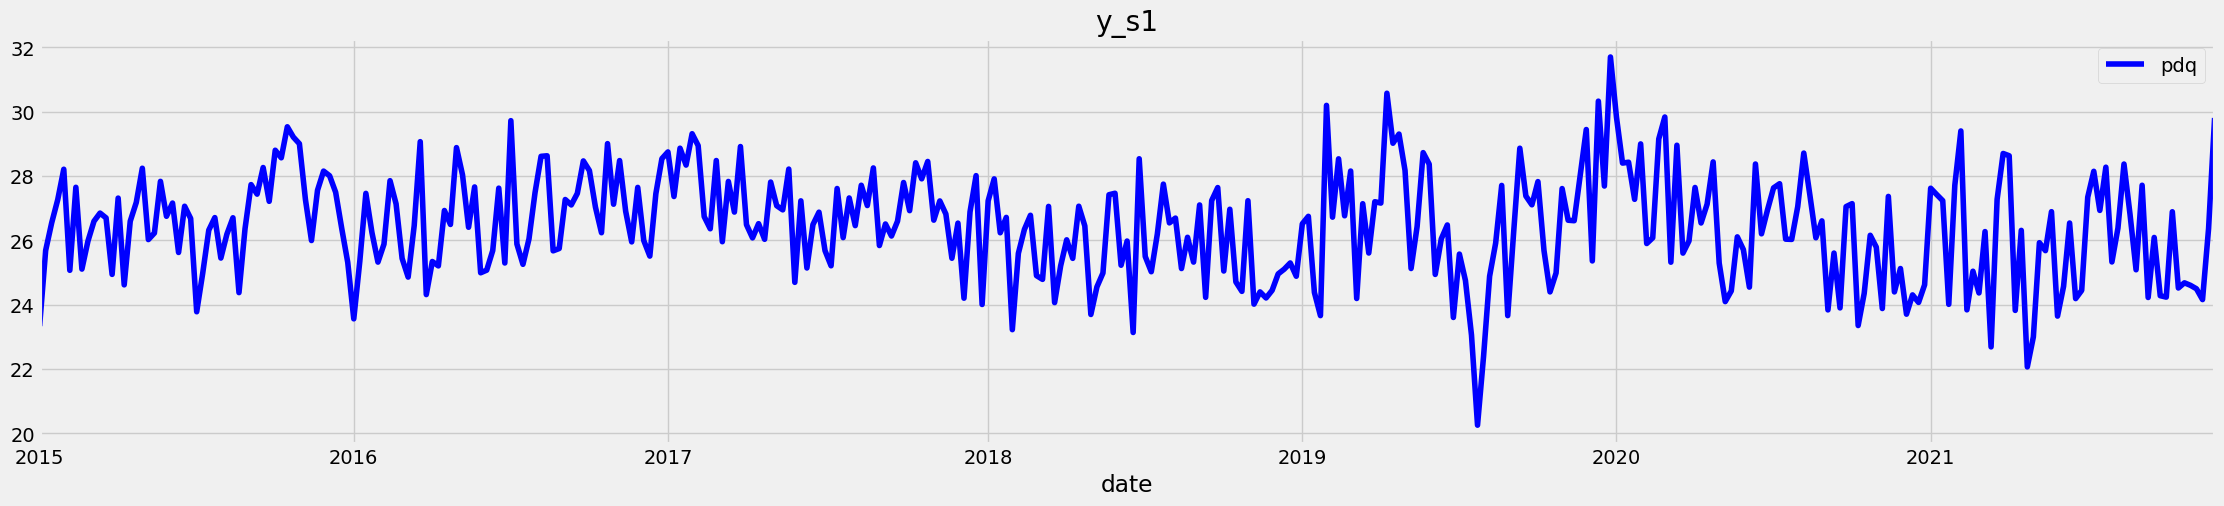

In [6]:
y_s1.plot(figsize=(25,5), color = "blue")
plt.title("y_s1")
plt.show()

Para la tendencia, se mantiene "estable" durante los años, no se ven patrones con variaciones abruptas y para la estacionalidad se observa que siempre hay picos y caidas durante los años.

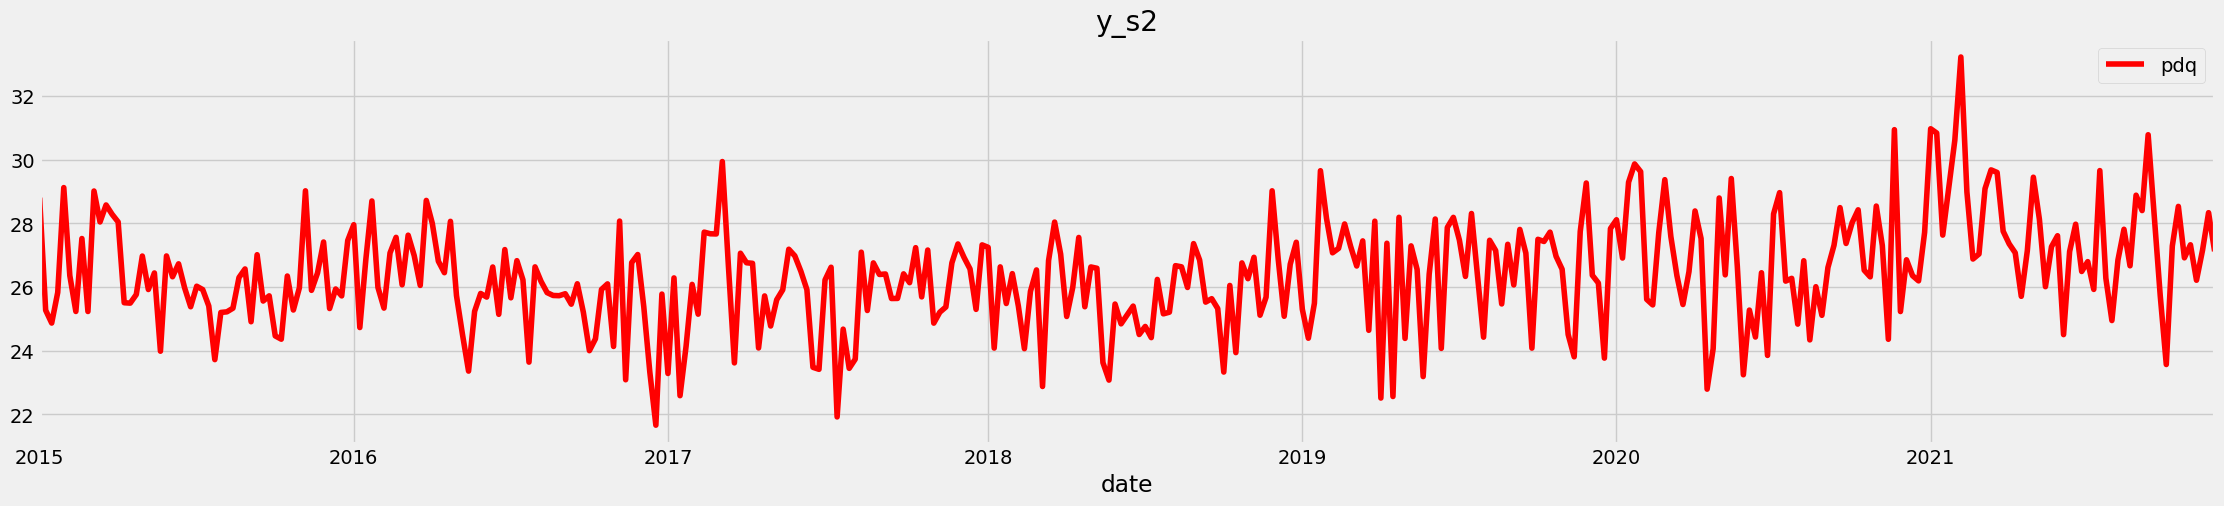

In [7]:
y_s2.plot(figsize=(25,5), color = "red")
plt.title("y_s2")
plt.show()

Muestra una tendencia levemente creciente, las variaciones semanales son más frecuentes en comparación a y_s1, además que más abruptas. Finalmente la estacionalidad se aprecian picos y caídas más marcadas que en y_s1 durante los años.

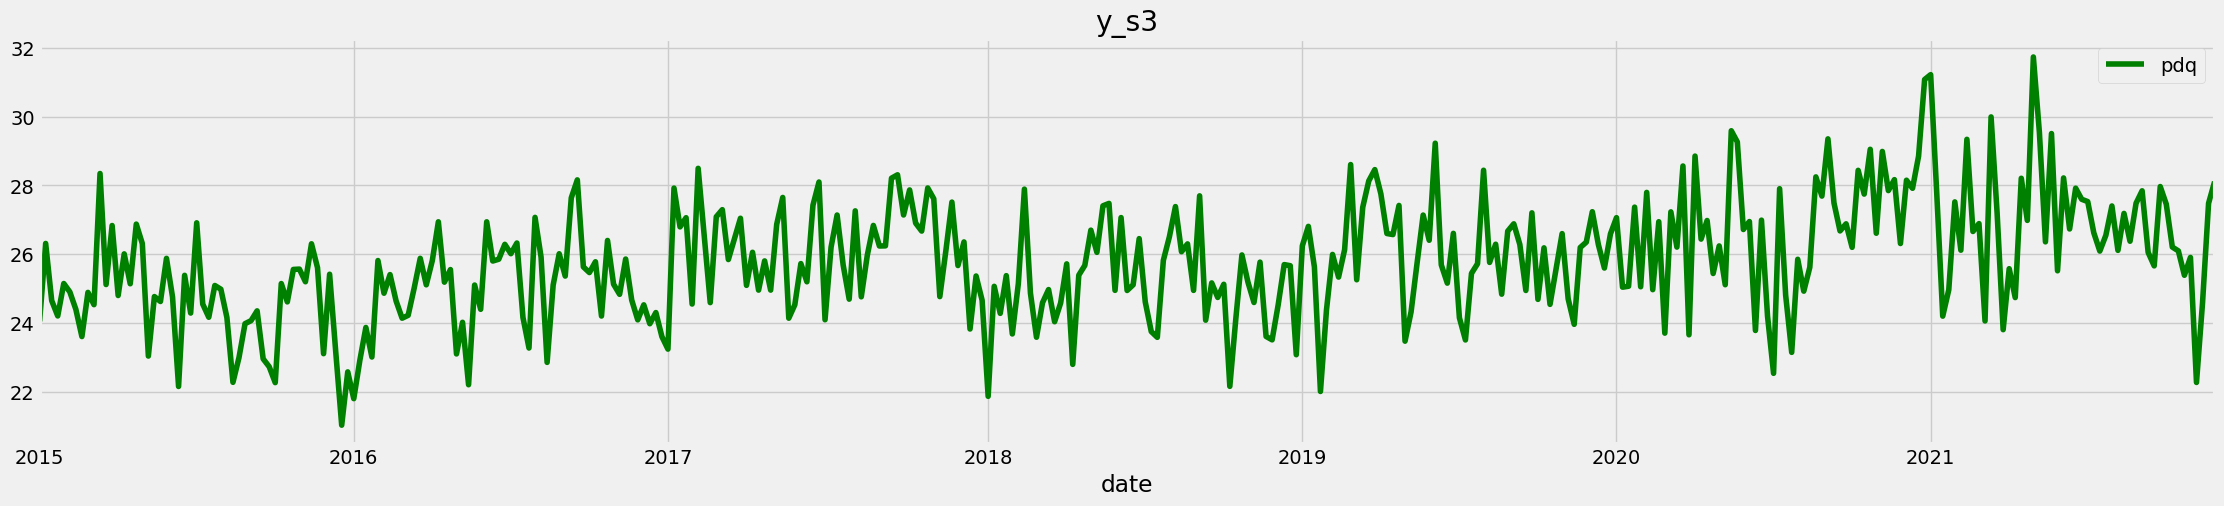

In [8]:
y_s3.plot(figsize=(25,5), color = "green")
plt.title("y_s3")
plt.show()

La tendencia creciente, solo en 2017-2018 estuvo estable, y se aprecia una estacionalidad leve por cada 1er trimestre del año y los patrones, se distingue una variabilidad más constante, con oscilaciones regulares y pocos valores extremos.

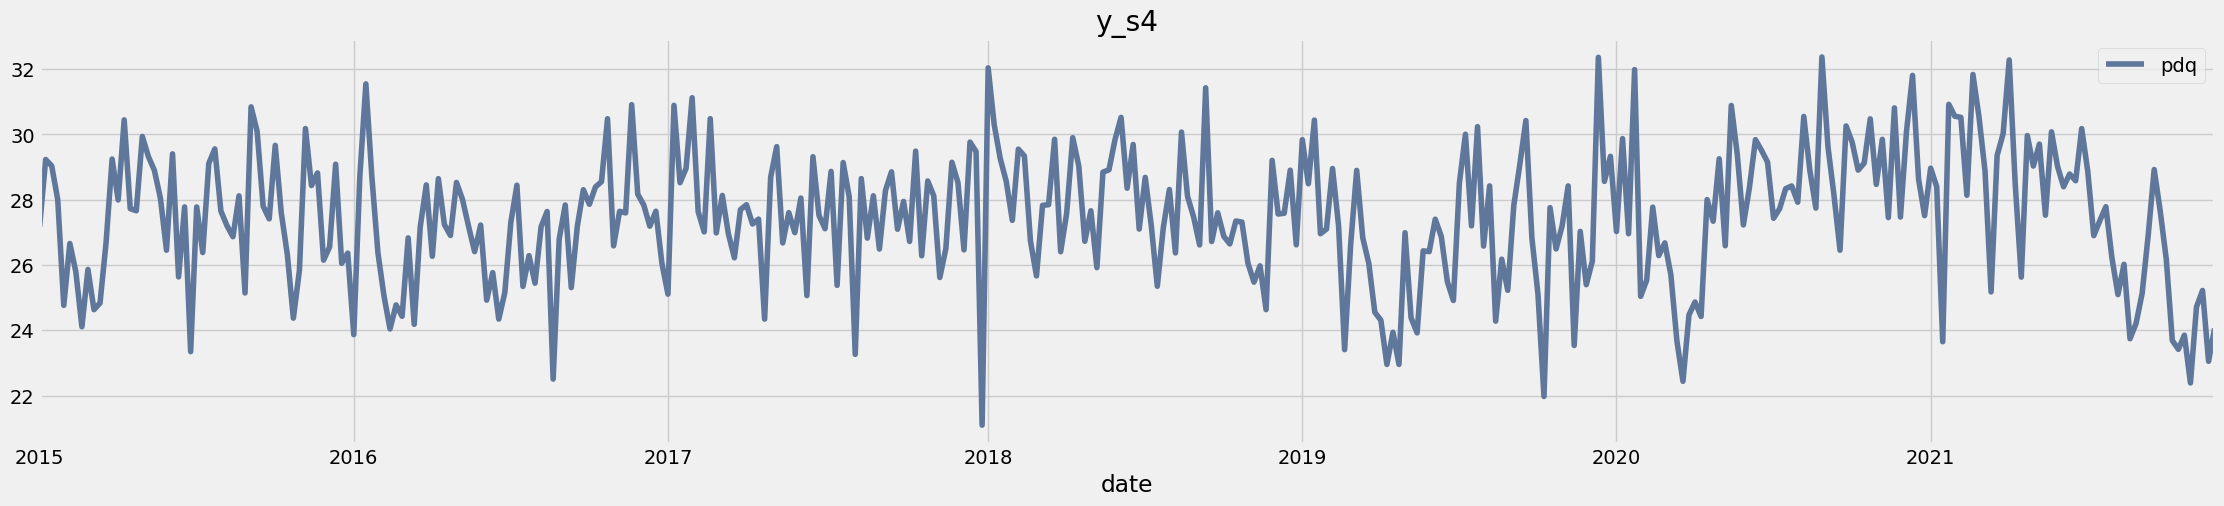

In [9]:
y_s4.plot(figsize=(25,5))
plt.title("y_s4")
plt.show()

Tendencia "estable", se aprecia una estacionalidad leve por cada fin de año, con picos y caidas, además de patrones de picos más notables en comparación a y_s3.



1. Seleccione una de las series temporales \$y\_{si}, ; i=1,2,3,4\$ y desarrolle lo siguiente:

* **Análisis exploratorio**: examine la serie elegida identificando patrones, tendencias y posibles estacionalidades.
* **Modelado con SARIMA**: ajuste un modelo \$SARIMA(p,d,q) \times (P,D,Q,S)\$ probando distintas configuraciones de hiperparámetros. Compare resultados, seleccione la mejor configuración y justifique su elección.
* **Validación del modelo**: evalúe los residuos del modelo óptimo y determine si se comportan como **ruido blanco**.

> **Nota**: Utilice como `target_date` = `'2021-01-01'`. Recuerde que la columna de valores se llama `pdq`.



In [10]:
# creando clase SarimaModels

class SarimaModels:
    def __init__(self,params):

        self.params = params


    @property
    def name_model(self):
        return f"SARIMA_{self.params[0]}X{self.params[1]}".replace(' ','')

    @staticmethod
    def test_train_model(y,date):
        mask_ds = y.index < date

        y_train = y[mask_ds]
        y_test = y[~mask_ds]

        return y_train, y_test

    def fit_model(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        return model_fit

    def df_testig(self,y,date):
        y_train, y_test = self.test_train_model(y,date )
        model = SARIMAX(y_train,
                        order=self.params[0],
                        seasonal_order=self.params[1],
                        enforce_stationarity=False,
                        enforce_invertibility=False)

        model_fit = model.fit(disp=0)

        start_index = y_test.index.min()
        end_index = y_test.index.max()

        preds = model_fit.get_prediction(start=start_index,end=end_index, dynamic=False)
        df_temp = pd.DataFrame(
            {
                'y':y_test['pdq'],
                'yhat': preds.predicted_mean
            }
        )

        return df_temp

    def metrics(self,y,date):
        df_temp = self.df_testig(y,date)
        df_metrics = summary_metrics(df_temp)
        df_metrics['model'] = self.name_model

        return df_metrics

# definir parametros

import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

params = list(itertools.product(pdq,seasonal_pdq))
target_date = '2021-01-01'

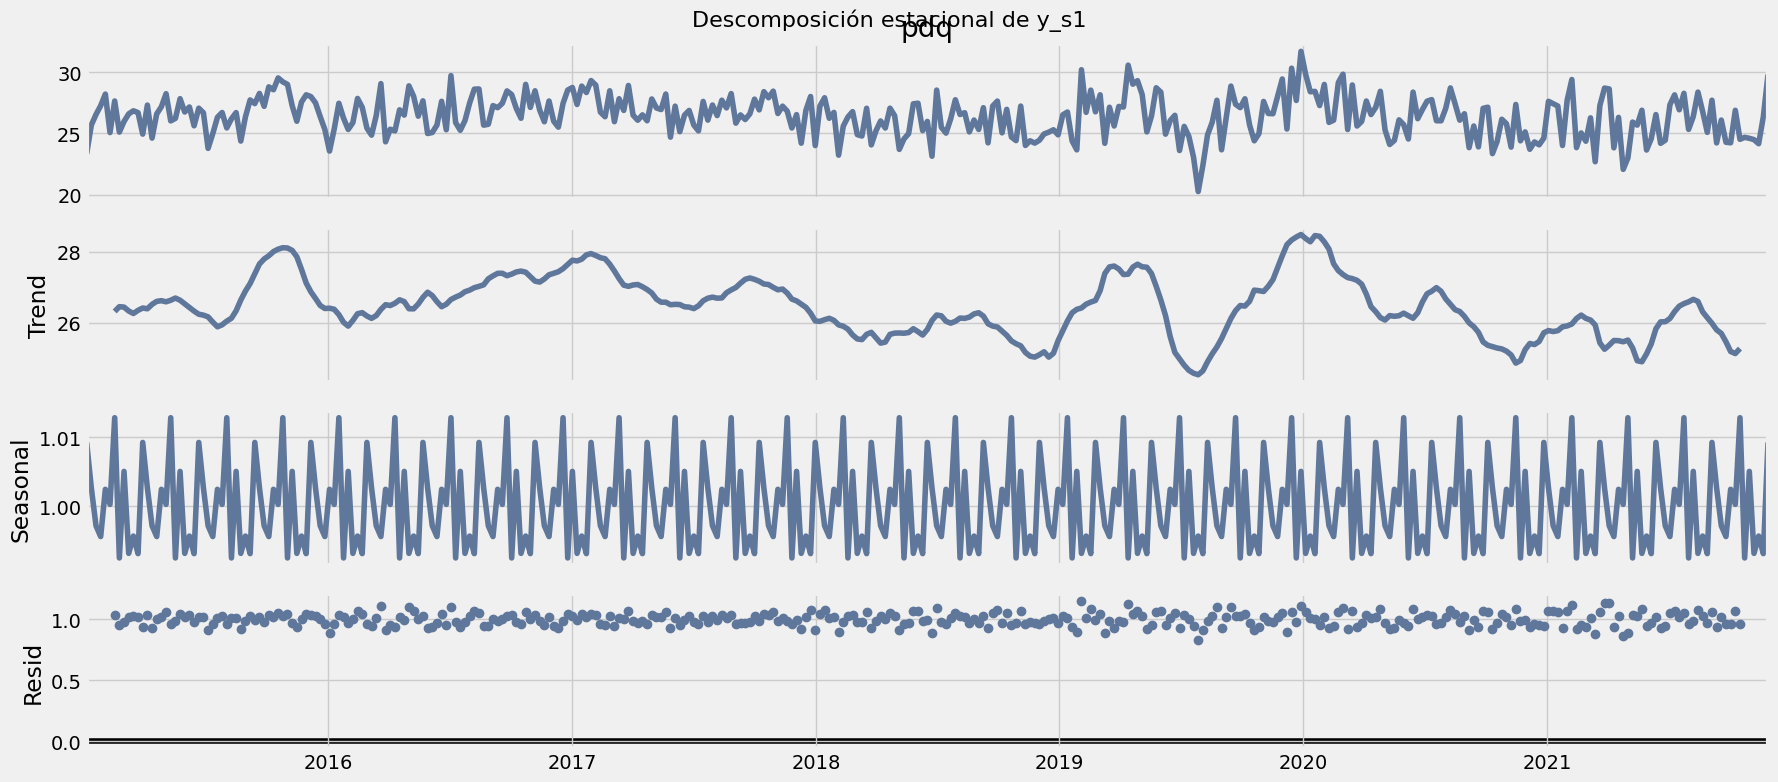

In [11]:
#2.1, usando y_s1
from pylab import rcParams

rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y_s1['pdq'], model='multiplicative', period=12)
fig = decomposition.plot()
plt.suptitle('Descomposición estacional de y_s1', fontsize=16)
plt.show()

Trend: Entre 2015 y 2017 hay un ligero aumento en los valores medios, luego, durante 2018–2019 se aprecia una leve disminución. Finalmente hacia 2020–2021 se observa una recuperación, aunque con mayor volatilidad. Por lo tanto, la serie no es completamente estacionaria

Seasonal: Los valores máximos y mínimos se repiten en intervalos fijos, esto indica que la variable tiene fluctuaciones predecibles a lo largo del año.

Resid: El componente de residuo se distribuye alrededor de 1 (en el modelo multiplicativo), con cierta variabilidad, pero sin un patrón claro.

En general, la serie y_s1 muestra fluctuaciones moderadas alrededor de un nivel medio cercano a 25–30 delitos.

In [12]:
#2.2, entrenar y comparar modelos SARIMA
results = []

for p in params:
    try:
        sarima = SarimaModels(p)
        metrics_df = sarima.metrics(y_s1, target_date)
        results.append(metrics_df)
    except Exception as e:
        print(f"Error con {p}: {e}")
df_results = pd.concat(results).sort_values(by='rmse')
df_results.head()

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614,"SARIMA_(0,0,0)X(1,0,1,12)"
0,1.5934,3.4304,1.8521,0.0624,0.0622,0.0616,0.0600,0.0616,"SARIMA_(0,0,1)X(1,0,1,12)"
0,1.6021,3.4537,1.8584,0.0627,0.0625,0.0619,0.0603,0.0619,"SARIMA_(1,0,0)X(1,0,1,12)"
0,1.6444,3.7833,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(1,1,1,12)"
0,1.6444,3.7832,1.9451,0.0654,0.0651,0.0635,0.0629,0.0635,"SARIMA_(0,0,0)X(0,1,1,12)"


In [13]:
#2.2, selección mejor modelo, usando criterio RMSE (menor RMSE)
mejor_modelo = eval(df_results.iloc[0]['model'].replace('SARIMA_', '').replace('X', ','))
print("Mejores parámetros:", mejor_modelo)

Mejores parámetros: ((0, 0, 0), (1, 0, 1, 12))


Justificación: El modelo que mostró el mejor desempeño fue SARIMA(0,0,0) X (1,0,1,12), ya que este posee menor RMSE, así explicando mejor los datos, porque RMSE mide el error promedio de predicción en las mismas unidades de la serie original.

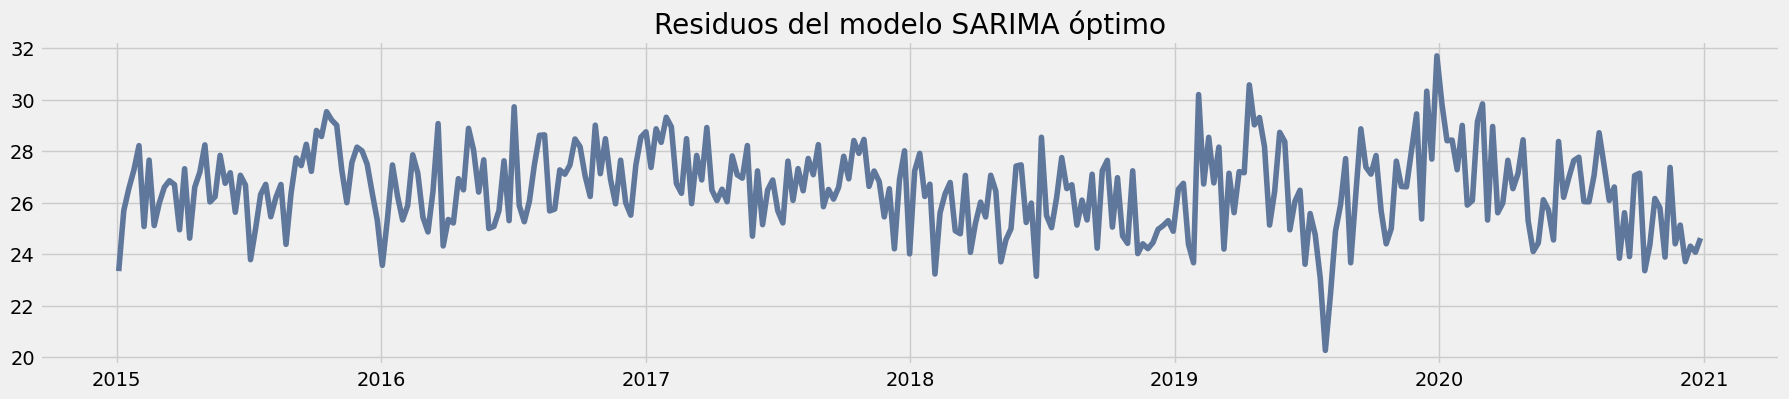

In [14]:
#2.3, validar modelo óptimo
m_parametros = params[0]
model = SarimaModels(m_parametros)
model_fit = model.fit_model(y_s1, target_date)

residual = model_fit.resid

plt.figure(figsize=(20,4))
plt.plot(residual)
plt.title("Residuos del modelo SARIMA óptimo")
plt.show()

In [15]:
#2.3, ruido blanco?
from statsmodels.stats.diagnostic import acorr_ljungbox

ljung = acorr_ljungbox(residual, lags=[10,20,30], return_df=True)
print(ljung)

       lb_stat     lb_pvalue
10  111.892164  2.215090e-19
20  124.689166  3.836279e-17
30  139.145701  5.424239e-16


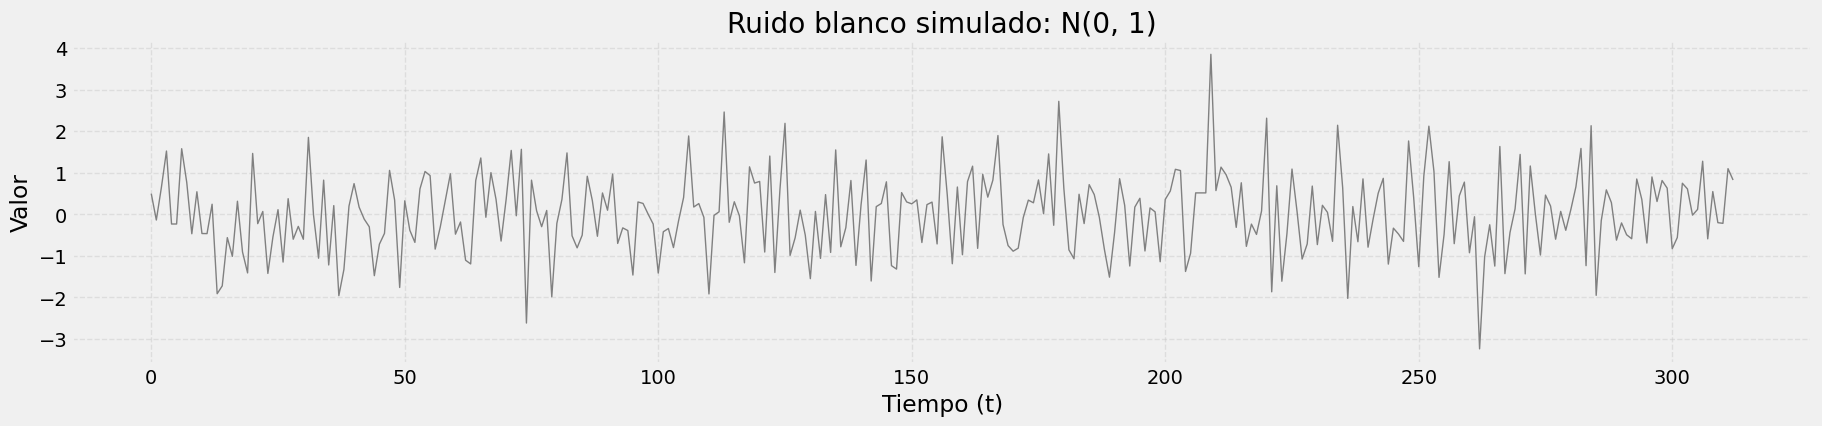

In [16]:
#2.3 ruido blanco
np.random.seed(42)
samples = np.random.normal(0, 1, len(residual))

plt.figure(figsize=(20, 4))
plt.plot(samples, color='gray', linewidth=1)
plt.title("Ruido blanco simulado: N(0, 1)")
plt.xlabel("Tiempo (t)")
plt.ylabel("Valor")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

El gráfico muestra un ruido blanco, es decir, una serie de valores aleatorios sin patrón. Los puntos suben y bajan sin tendencia ni repetición, oscilando alrededor de cero.




3. Resuelva el ejercicio anterior utilizando la librería **`Prophet`**, desarrollada por Facebook para el modelado de series temporales.

* **Ajuste del modelo**: entrene un modelo con `Prophet` sobre la misma serie seleccionada en el punto anterior.
* **Evaluación del desempeño**: compare la capacidad predictiva de `Prophet` frente al modelo **SARIMA** previamente ajustado, considerando métricas de error (por ejemplo, MAE, RMSE o MAPE).
* **Análisis comparativo**: discuta las diferencias en los supuestos de ambos métodos, su facilidad de implementación y la calidad de las predicciones obtenidas.
* **Conclusiones**: señale en qué situaciones `Prophet` puede ser preferible a SARIMA y viceversa.


In [17]:
from prophet import Prophet
#3.1
df_prophet = y_s1.reset_index()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'pdq': 'y'})

mask_ds_prophet = df_prophet['ds'] < target_date
y_train_prophet = df_prophet[mask_ds_prophet]
y_test_prophet = df_prophet[~mask_ds_prophet]

model_prophet = Prophet(
    seasonality_mode='multiplicative',
    yearly_seasonality=True
)
model_prophet.fit(y_train_prophet)

print("Modelo Prophet entrenado exitosamente.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Modelo Prophet entrenado exitosamente.


In [19]:
#3.1
future = model_prophet.make_future_dataframe(
    periods=len(y_test_prophet),
    freq='W',
    include_history=False
)

last_train_date = y_train_prophet['ds'].max()
future = future[future['ds'] > last_train_date]

forecast = model_prophet.predict(future)

df_prophet_metrics = pd.DataFrame({
    'y': y_test_prophet['y'].values,
    'yhat': forecast['yhat'].values
})

print("Predicciones de Prophet generadas.")


Predicciones de Prophet generadas.


In [23]:
#3.2
df_prophet_eval_metrics = summary_metrics(df_prophet_metrics)
df_prophet_eval_metrics['model'] = 'Prophet'
display(df_prophet_eval_metrics)


,mae,mse,rmse,mape,maape,wmape,mmape,smape,model
0,1.7039,4.1073,2.0267,0.0668,0.0666,0.0658,0.0643,0.0658,Prophet


Análisis: Observando las métricas de error, SARIMA(0,0,0)X(1,0,1,12) obtuvo un RMSE de 1.8500 y un MAE de 1.5876, mientras que Prophet tuvo un RMSE de 2.0267 y un MAE de 1.7039. En este caso específico, el modelo SARIMA mostró un rendimiento ligeramente superior en términos de precisión predictiva (menores errores) para la serie y_s1

In [22]:
#3.3
best_sarima_metrics = df_results.iloc[0:1]

# Concatenar y mostrar las métricas de ambos modelos
comparison_metrics = pd.concat([best_sarima_metrics, df_prophet_eval_metrics])
display(comparison_metrics.set_index('model'))


,mae,mse,rmse,mape,maape,wmape,mmape,smape
model,,,,,,,,
"SARIMA_(0,0,0)X(1,0,1,12)",1.5876,3.4224,1.8500,0.0622,0.0620,0.0614,0.0599,0.0614
Prophet,1.7039,4.1073,2.0267,0.0668,0.0666,0.0658,0.0643,0.0658


Supuestos y enfoque:

Sarima: Es un modelo estadístico tradicional que trabaja bien si la serie es estable o puede estabilizarse al eliminar tendencias. Se basa en relaciones lineales entre los datos pasados y presentes. Requiere elegir manualmente varios parámetros (p, d, q, P, D, Q, S).

Prophet: Creado por Facebook, separa la serie en tres partes: tendencia, estacionalidad y efectos especiales (como feriados). No necesita que la serie sea estable y maneja bien datos faltantes o valores raros. Es más flexible y no depende tanto de supuestos estadísticos.

Facilidad de implementación:

SARIMA: Más complejo de configurar, porque hay que probar distintas combinaciones de parámetros y entender gráficos específicos para elegir los correctos. Es más técnico y puede tardar en encontrar el mejor modelo.

Prophet: Mucho más fácil de usar. Con pocas líneas de código se puede entrenar un modelo funcional. Detecta estacionalidades automáticamente y permite agregar feriados o eventos fácilmente. Es ideal cuando se busca rapidez y simplicidad sin entrar en detalles estadísticos complejos.

###3.4: Conclusiones

SARIMA es mejor cuando: La serie tiene patrones regulares y se comporta de forma relativamente estable, si también se cuenta con conocimientos estadísticos para ajustar correctamente los parámetros, si se busca un modelo más técnico y explicable desde el punto de vista estadístico y si hay tiempo y recursos para probar distintas configuraciones, ya que puede ofrecer una precisión ligeramente superior si se ajusta bien.

Finalmente, Prophet es mejor cuando: Se necesita rapidez y facilidad para generar pronósticos, si la serie tiene estacionalidades complejas, datos faltantes o cambios bruscos, si no se tiene mucha experiencia en modelos estadísticos avanzados, si se requiere interpretar fácilmente la tendencia y la estacionalidad, algo útil en contextos de negocio y si la serie es larga o presenta varios patrones estacionales, ya que Prophet los maneja automáticamente.